In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score,fbeta_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

from catboost import CatBoostClassifier
import shap

import warnings
warnings.filterwarnings("ignore") 

In [92]:
train = pd.read_csv('df_train_ADASYN_UP_MinMax.csv')
df_t = pd.read_csv('df_test_ADASYN_UP_MinMax.csv')

X = train.drop(['target'],axis=1)#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t.drop(['client_id', 'dt', 'target'],axis=1)#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.5979975	total: 91.6ms	remaining: 1m 31s
100:	learn: 0.3455819	total: 9.89s	remaining: 1m 28s
200:	learn: 0.3164117	total: 19.2s	remaining: 1m 16s
300:	learn: 0.2924922	total: 28.6s	remaining: 1m 6s
400:	learn: 0.2725015	total: 37.8s	remaining: 56.5s
500:	learn: 0.2547073	total: 47.4s	remaining: 47.2s
600:	learn: 0.2381708	total: 56.8s	remaining: 37.7s
700:	learn: 0.2235225	total: 1m 6s	remaining: 28.3s
800:	learn: 0.2096414	total: 1m 15s	remaining: 18.9s
900:	learn: 0.1972570	total: 1m 25s	remaining: 9.38s
999:	learn: 0.1856297	total: 1m 35s	remaining: 0us
gini:  0.726
f1_score:  0.402
accuracy_score:  0.894
recall_score:  0.551
precision_score:  0.316


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


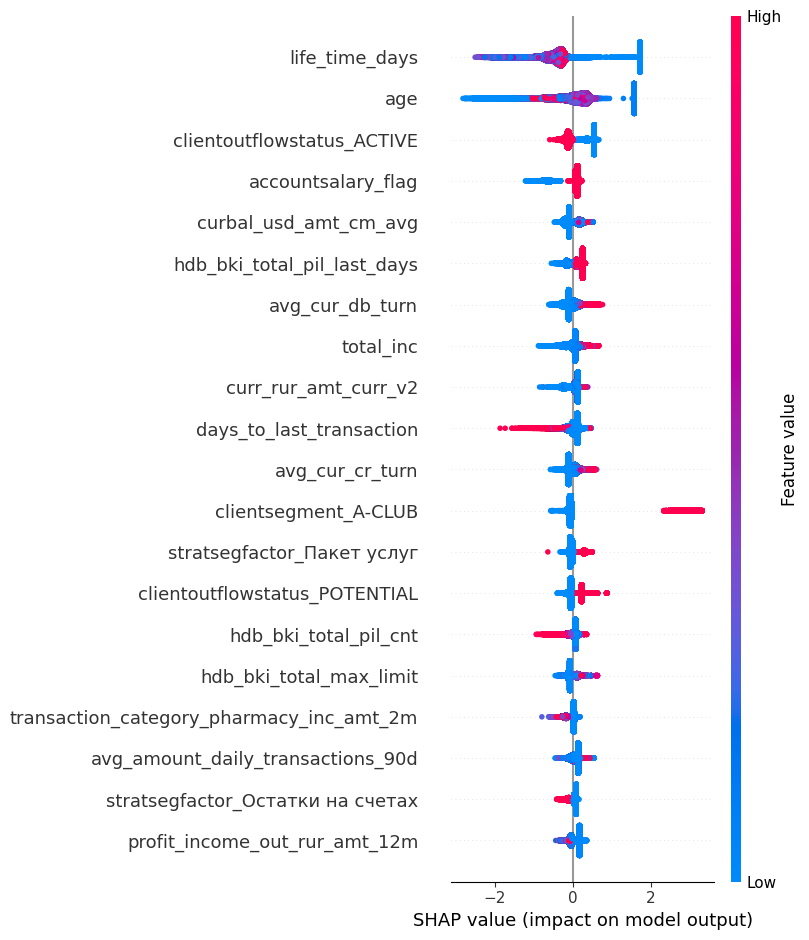

In [94]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [96]:
feature_names = X.columns
shap_df = pd.DataFrame(shap_values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
253,life_time_days,0.733144
70,age,0.513822
249,clientoutflowstatus_ACTIVE,0.223828
221,accountsalary_flag,0.176640
143,curbal_usd_amt_cm_avg,0.169538
...,...,...
24,clientsegment_nan,0.000000
240,addrref,0.000000
180,srvpackage,0.000000
166,country,0.000000


In [ ]:
top_60 = shap_importance.iloc[:60]['col_name'].values

In [104]:
X = train[top_60]#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t[top_60]#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.6019447	total: 72.5ms	remaining: 1m 12s
100:	learn: 0.3472840	total: 5.91s	remaining: 52.6s
200:	learn: 0.3205119	total: 11.7s	remaining: 46.4s
300:	learn: 0.2989610	total: 17.5s	remaining: 40.6s
400:	learn: 0.2805716	total: 23.4s	remaining: 35s
500:	learn: 0.2637834	total: 29.2s	remaining: 29.1s
600:	learn: 0.2489683	total: 35.3s	remaining: 23.4s
700:	learn: 0.2352680	total: 41.1s	remaining: 17.5s
800:	learn: 0.2232246	total: 47s	remaining: 11.7s
900:	learn: 0.2116670	total: 52.8s	remaining: 5.8s
999:	learn: 0.2012781	total: 58.6s	remaining: 0us
gini:  0.713
f1_score:  0.385
accuracy_score:  0.883
recall_score:  0.564
precision_score:  0.292


Удалим признаки с корреляцией > 0.9 по степени важности по shap

In [106]:
corr_t = train[top_60].corr()

In [135]:
top = list(set(top_60)-set(['avg_cur_db_turn','curr_rur_amt_3m_avg','avg_amount_daily_transactions_30d','profit_income_out_rur_amt_9m', 'transaction_category_supermarket_inc_amt_2m', 'avg_cnt_daily_transactions_90d' ]))

Итоговый список фичей

In [143]:
top

['clientsegment_MAFFLUENT',
 'transaction_category_cash_percent_amt_2m',
 'days_to_last_transaction',
 'hdb_bki_total_pil_cnt',
 'curr_rur_amt_cm_avg',
 'clientoutflowstatus_ACTIVE',
 'clientsegment_A-CLUB',
 'accountsalary_flag',
 'life_time_days',
 'gender_Мужской',
 'amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__tovary_i_uslugi',
 'amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__fastfud',
 'hdb_bki_total_max_limit',
 'hdb_bki_total_pil_max_limit',
 'sal_rur_amt_curr_v2',
 'transaction_category_supermarket_percent_cnt_2m',
 'amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__sportivnaja_odezhda',
 'total_inc',
 'transaction_category_pharmacy_percent_cnt_2m',
 'transaction_category_supermarket_sum_amt_m2',
 'curr_rur_amt_curr_v2',
 'curbal_usd_amt_cm_avg',
 'hdb_bki_total_cc_last_days',
 'hdb_bki_last_product_days',
 'stratsegfactor_Пакет услуг',
 'total_rur_amt_curr_v2',
 'avg_amount_daily_transactions_90d',
 'hdb_bki_total_active_

In [142]:
corr_t[(corr_t>0.9)&(corr_t!=1)].isna().sum()

clientsegment_MAFFLUENT                                                                  54
transaction_category_cash_percent_amt_2m                                                 54
days_to_last_transaction                                                                 54
hdb_bki_total_pil_cnt                                                                    54
curr_rur_amt_cm_avg                                                                      54
clientoutflowstatus_ACTIVE                                                               54
clientsegment_A-CLUB                                                                     54
accountsalary_flag                                                                       54
life_time_days                                                                           54
gender_Мужской                                                                           54
amount_by_category_90d__summarur_amt__SUM__cashflowcategory_name__tovary_i_uslug

In [144]:
X = train[top]#.to_numpy()
y = train['target'].to_numpy()
model = CatBoostClassifier()
model.fit(X, y, verbose=100, plot=False)

X_t = df_t[top]#.to_numpy()
y_t = df_t['target'].to_numpy()

pred_proba = model.predict_proba(X_t)[:,1]
print('gini: ', round(2*roc_auc_score(y_t, pred_proba)-1,3))
pred = model.predict(X_t)
print('f1_score: ', round(f1_score(y_t, pred),3))
print('accuracy_score: ', round(accuracy_score(y_t, pred),3))
print('recall_score: ', round(recall_score(y_t, pred),3))
print('precision_score: ', round(precision_score(y_t, pred),3))

Learning rate set to 0.110778
0:	learn: 0.6069255	total: 67ms	remaining: 1m 6s
100:	learn: 0.3485233	total: 5.68s	remaining: 50.6s
200:	learn: 0.3220555	total: 11.5s	remaining: 45.7s
300:	learn: 0.3005662	total: 17.3s	remaining: 40.1s
400:	learn: 0.2812870	total: 23.1s	remaining: 34.4s
500:	learn: 0.2651877	total: 28.8s	remaining: 28.6s
600:	learn: 0.2507793	total: 34.5s	remaining: 22.9s
700:	learn: 0.2372679	total: 40.2s	remaining: 17.1s
800:	learn: 0.2245439	total: 46s	remaining: 11.4s
900:	learn: 0.2131975	total: 51.8s	remaining: 5.69s
999:	learn: 0.2025709	total: 57.4s	remaining: 0us
gini:  0.715
f1_score:  0.389
accuracy_score:  0.883
recall_score:  0.574
precision_score:  0.294


In [ ]:
train[top+['target']].to_csv('train_1.csv', index = False)
df_t[top+['target']].to_csv('test_1.csv', index = False)